# HOMEWORK 1
Shanice Bailey

03-16-2020

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.xarray
import xmitgcm
xmitgcm.file_utils.clear_cache()

In [ ]:
rundir = '/rigel/ocp/users/stb2145/tutorial_barotropic_gyre/run'
ds = xmitgcm.open_mdsdataset(rundir, iters=72*np.arange(1,201),
                             delta_t=1200, calendar='360_day', ref_date='0000-01-01 00:00:00')

In [ ]:
coords = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)
ds

In [6]:
import xgcm
metrics = {
    ('X',): ['dxC', 'dxG'],
    ('Y',): ['dyC', 'dyG'],
    ('Z',): ['drC', 'drF'],
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw']
}

grid = xgcm.Grid(coords, metrics=metrics, periodic=True)
grid

<xgcm.Grid>
Y Axis (periodic):
  * center   YC --> left
  * left     YG --> center
Z Axis (periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center
T Axis (periodic):
  * center   time

In [7]:
U_center = grid.interp(ds.U, 'X', boundary='fill')
V_center = grid.interp(ds.V, 'Y', boundary='fill')

# Problem 2

## • MITgcm's full solution
$$
\psi = - \int_0^y dy' \int_{-H}^0 dz u(x,y',z,t)
$$

In [9]:
ψ = -grid.cumint(ds.U * coords.drF[0], 'Y', boundary='fill')/1e6
ψ

<xarray.DataArray 'concatenate-9875394b7b7661dd7779916ee132c790' (time: 200, YG: 62, XG: 62)>
dask.array<truediv, shape=(200, 62, 62), dtype=float32, chunksize=(1, 61, 62), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-01-02 00:00:00 ... 0000-07-21 00:00:00
  * YG       (YG) >f4 -20000.0 0.0 20000.0 ... 1160000.0 1180000.0 1200000.0
  * XG       (XG) >f4 -20000.0 0.0 20000.0 ... 1160000.0 1180000.0 1200000.0

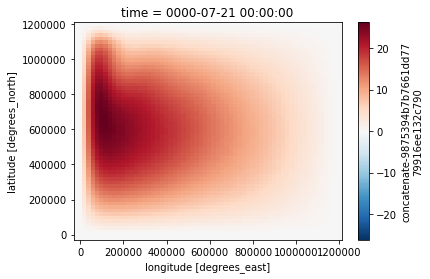

In [10]:
ψ[-1].plot()

In [12]:
#function to take the curl(var)
def curl(u, v):
    return(-grid.diff(u * coords.dxC, 'Y', boundary='extend') +
           grid.diff(v * coords.dyC, 'X', boundary='extend')) / ds.rAz

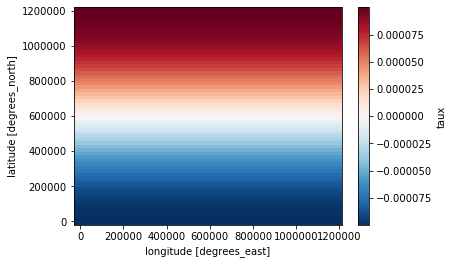

In [13]:
#read windstress
dtype = '>f4'
taux_data = np.fromfile(f'{rundir}/windx_cosy.bin', dtype=dtype)
taux_data.shape = coords.rA.shape
rho0 = 1000.
ds['taux'] = ('YC', 'XG'), taux_data / rho0
ds.taux.plot()

## • Stommel's solution:
$$
\Psi = \frac{\tau_0 \pi}{\beta}(1 - \frac{x}{a} - e^{-\frac{x}{a\epsilon}})sin(\frac{\pi y}{a})
$$

In [14]:
rho0 = 1000 #kg/m^3
tau_0 = 0.1 #N/m^2
beta = 1e-11 #(sm)^-1
r = 1e-6 #why is it to 1e-6??
a = coords.YG[-1].values
epsilon = r / (beta * a)
x = coords.XG
y = coords.YG

In [15]:
psi = ((tau_0*np.pi) / beta) * (1 - (x / a) - np.e**(- (x / (a*epsilon)))) * np.sin((np.pi*y) / a)
psi_2 = ((0.2*np.pi) / beta) * (1 - (x / a) - np.e**(- (x / (a*epsilon)))) * np.sin((np.pi*y) / a)

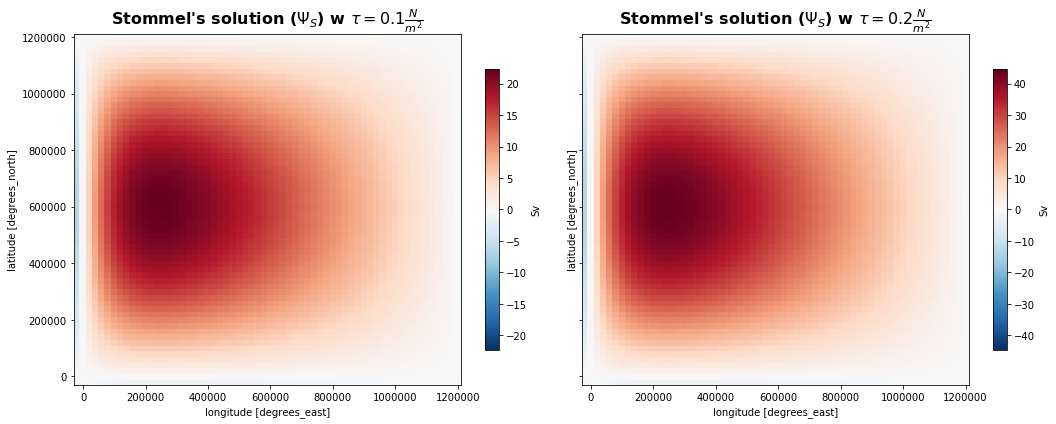

In [18]:
#Sv after dividing by rho0
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,6), sharey=True)

(psi/(rho0*1e6)).transpose().plot(cbar_kwargs={'shrink' : 0.8, 'label':'Sv'}, ax=ax0)
ax0.set_title(r"Stommel's solution ($\Psi_S$) w $\tau = 0.1 \frac{N}{m^2}$", fontsize=16, weight='bold')

(psi_2/(rho0*1e6)).transpose().plot(cbar_kwargs={'shrink' : 0.8, 'label':'Sv'}, ax=ax1)
ax1.set_title(r"Stommel's solution ($\Psi_S$) w $\tau = 0.2 \frac{N}{m^2}$", fontsize=16, weight='bold')
plt.tight_layout();

### Plotting difference between Full solution and Stommel's solution

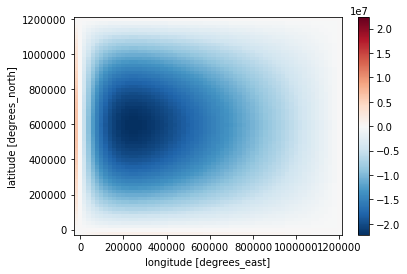

In [25]:
(full_sol - (psi/(rho0*1e6))).plot()